The objective of this notebook is to demonstrate splitting a log_prob and gradient computation across a number of GPU devices. For development purposes, this was prototyped in colab with a single GPU partitioned into multiple logical GPUs. 

*Note*: Since it runs on a single GPU, performance is not representative of what can be achieved with multiple GPUs. Usage of `tf.data` can likely benefit from some tuning when deployed to multiple GPUs.

**Needs a GPU**: Edit > Notebook Settings: `Hardware Accelerator` => `GPU`

In [1]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb, tfd = tfp.bijectors, tfp.distributions

physical_gpus = tf.config.experimental.list_physical_devices('GPU')
print(physical_gpus)

tf.config.experimental.set_virtual_device_configuration(
    physical_gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)] * 4)
gpus = tf.config.list_logical_devices('GPU')
print(gpus)

st = tf.distribute.MirroredStrategy(devices=tf.config.list_logical_devices('GPU'))
print(st.extended.worker_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [2]:
# Draw samples from an MVN, then sort them. This way we can easily visually
# verify the correct partition ends up on the correct GPUs.
ndim = 3

def model():
  Root = tfd.JointDistributionCoroutine.Root
  loc = yield Root(tfb.Shift(.5)(tfd.MultivariateNormalDiag(loc=tf.zeros([ndim]))))
  scale_tril = yield Root(tfb.FillScaleTriL()(tfd.MultivariateNormalDiag(loc=tf.zeros([ndim * (ndim + 1) // 2]))))
  yield tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)

dist = tfd.JointDistributionCoroutine(model)
loc, scale_tril, _ = dist.sample()

samples = dist.sample(value=([loc] * 1024, scale_tril, None))[2]
samples = tf.round(samples * 1000) / 1000
for dim in reversed(range(ndim)):
  samples = tf.gather(samples, tf.argsort(samples[:,dim]))

print(samples)

tf.Tensor(
[[-4.321 -3.949  0.829]
 [-4.319 -3.059 -0.807]
 [-3.57  -4.558  2.111]
 ...
 [ 6.096  3.855  1.023]
 [ 6.334  4.514 -0.827]
 [ 6.928  3.033  3.634]], shape=(1024, 3), dtype=float32)


In [3]:
print(loc)
print(scale_tril)
print(tf.reduce_mean(samples, 0))

tf.Tensor([0.9930537  0.01916379 0.7527114 ], shape=(3,), dtype=float32)
tf.Tensor(
[[ 1.7327604   0.          0.        ]
 [ 1.3935078   1.0557237   0.        ]
 [-0.19117251 -1.90322     0.5102539 ]], shape=(3, 3), dtype=float32)
tf.Tensor([ 0.8688329  -0.07779592  0.7639365 ], shape=(3,), dtype=float32)


### Single batch of data resident on GPU.

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
accept rate: 0.805
ess: [<tf.Tensor: shape=(3,), dtype=float32, numpy=array([34.39838 , 12.606365, 20.39939 ], dtype=float32)>, <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[45.11744 ,       nan,       nan],
       [57.438633, 29.309052,       nan],
       [34.366856, 26.247347, 36.570995]], dtype=float32)>]
tf.Tensor([0.78803474 0.3430337  0.5179331 ], shape=(3,), dtype=float32)


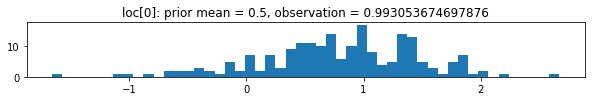

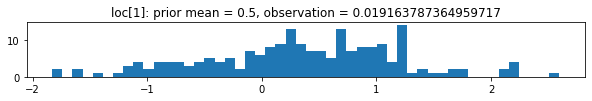

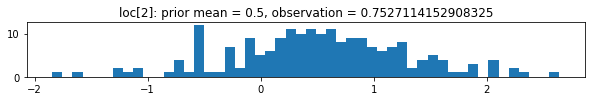

CPU times: user 15.4 s, sys: 2.06 s, total: 17.5 s
Wall time: 17.3 s


In [11]:
%%time

def dataset_fn(ctx):
  batch_size = ctx.get_per_replica_batch_size(len(samples))
  d = tf.data.Dataset.from_tensor_slices(samples).batch(batch_size)
  return d.shard(ctx.num_input_pipelines, ctx.input_pipeline_id)

ds = st.experimental_distribute_datasets_from_function(dataset_fn)

observations = next(iter(ds))
# print(observations)

def log_prob_and_grad(loc, scale_tril, observations):
  ctx = tf.distribute.get_replica_context()
  with tf.GradientTape() as tape:
    tape.watch((loc, scale_tril))
    lp = tf.reduce_sum(dist.log_prob(loc, scale_tril, observations)) / len(samples)
  grad = tape.gradient(lp, (loc, scale_tril))
  return ctx.all_reduce('sum', lp), [ctx.all_reduce('sum', g) for g in grad]

@tf.function(autograph=False)
@tf.custom_gradient
def target_log_prob(loc, scale_tril):
  lp, grads = st.experimental_run_v2(log_prob_and_grad, (loc, scale_tril, observations))
  return lp.values[0], lambda grad_lp: [grad_lp * g.values[0] for g in grads]

# print(tfp.math.value_and_gradient(target_log_prob, (loc, scale_tril)))

kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob, step_size=.35, num_leapfrog_steps=2)
kernel = tfp.mcmc.TransformedTransitionKernel(kernel, bijector=[tfb.Identity(), tfb.FillScaleTriL()])

@tf.function(autograph=False)
def sample_chain():
  return tfp.mcmc.sample_chain(
      num_results=200, num_burnin_steps=100,
      current_state=[tf.ones_like(loc), tf.linalg.eye(scale_tril.shape[-1])], 
      kernel=kernel, trace_fn=lambda _, kr: kr.inner_results.is_accepted)
samps, is_accepted = sample_chain()

print(f'accept rate: {np.mean(is_accepted)}')
print(f'ess: {tfp.mcmc.effective_sample_size(samps)}')

print(tf.reduce_mean(samps[0], axis=0))
# print(tf.reduce_mean(samps[1], axis=0))

import matplotlib.pyplot as plt
for dim in range(ndim):
  plt.figure(figsize=(10,1))
  plt.hist(samps[0][:,dim], bins=50)
  plt.title(f'loc[{dim}]: prior mean = 0.5, observation = {loc[dim]}')
  plt.show()

### Two batches of data per log-prob eval (2x slower).

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
accept rate: 0.79
ess: [<tf.Tensor: shape=(3,), dtype=float32, numpy=array([26.674135, 38.122704, 31.241467], dtype=float32)>, <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[54.29772 ,       nan,       nan],
       [38.399918, 46.97566 ,       nan],
       [29.181406, 34.569984, 35.78369 ]], dtype=float32)>]
tf.Tensor([0.58452165 0.18950851 0.7064446 ], shape=(3,), dtype=float32)


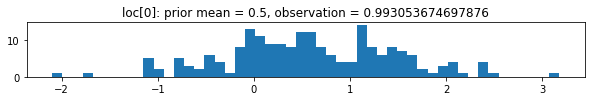

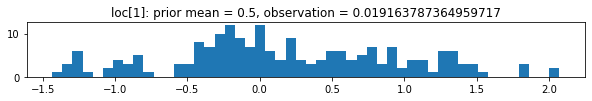

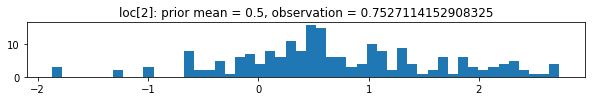

CPU times: user 1min 13s, sys: 9.15 s, total: 1min 22s
Wall time: 52.9 s


In [12]:
%%time
batches_per_eval = 2

def dataset_fn(ctx):
  batch_size = ctx.get_per_replica_batch_size(len(samples))
  d = tf.data.Dataset.from_tensor_slices(samples).batch(batch_size // batches_per_eval)
  return d.shard(ctx.num_input_pipelines, ctx.input_pipeline_id)

ds = st.experimental_distribute_datasets_from_function(dataset_fn)

def log_prob_and_grad(loc, scale_tril, observations, prev_sum_lp, prev_sum_grads):
  ctx = tf.distribute.get_replica_context()
  with tf.GradientTape() as tape:
    tape.watch((loc, scale_tril))
    lp = tf.reduce_sum(dist.log_prob(loc, scale_tril, observations)) / len(samples)
  grad = tape.gradient(lp, (loc, scale_tril))
  return lp + prev_sum_lp, [g + pg for (g, pg) in zip(grad, prev_sum_grads)]

@tf.function(autograph=False)
@tf.custom_gradient
def target_log_prob(loc, scale_tril):
  sum_lp = tf.zeros([])
  sum_grads = [tf.zeros_like(x) for x in (loc, scale_tril)]
  sum_lp, sum_grads = st.experimental_run_v2(
      lambda *x: tf.nest.map_structure(tf.identity, x), (sum_lp, sum_grads))
  def reduce_fn(state, observations):
    sum_lp, sum_grads = state
    return st.experimental_run_v2(
        log_prob_and_grad, (loc, scale_tril, observations, sum_lp, sum_grads))
  sum_lp, sum_grads = ds.reduce((sum_lp, sum_grads), reduce_fn)
  sum_lp = st.reduce('sum', sum_lp, None)
  sum_grads = [st.reduce('sum', sg, None) for sg in sum_grads]
  return sum_lp, lambda grad_lp: [grad_lp * sg for sg in sum_grads]

# print(tfp.math.value_and_gradient(target_log_prob, (loc, scale_tril)))

kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob, step_size=.35, num_leapfrog_steps=2)
kernel = tfp.mcmc.TransformedTransitionKernel(kernel, bijector=[tfb.Identity(), tfb.FillScaleTriL()])

@tf.function(autograph=False)
def sample_chain():
  return tfp.mcmc.sample_chain(
      num_results=200, num_burnin_steps=100,
      current_state=[tf.ones_like(loc), tf.linalg.eye(scale_tril.shape[-1])], 
      kernel=kernel, trace_fn=lambda _, kr: kr.inner_results.is_accepted)
samps, is_accepted = sample_chain()

print(f'accept rate: {np.mean(is_accepted)}')
print(f'ess: {tfp.mcmc.effective_sample_size(samps)}')

print(tf.reduce_mean(samps[0], axis=0))
# print(tf.reduce_mean(samps[1], axis=0))

import matplotlib.pyplot as plt
for dim in range(ndim):
  plt.figure(figsize=(10,1))
  plt.hist(samps[0][:,dim], bins=50)
  plt.title(f'loc[{dim}]: prior mean = 0.5, observation = {loc[dim]}')
  plt.show()